---
title: LWD Tirol Meteo Download Package
date: 2025-04-08
categories: [python-package, data-download]
image: "sd-crop.png"
description: "Python package for downloading meteorological data of stations by Avalanche Warning Service of Tyrol"
---


This package is meant to facilitate download meteorological data from the Avalanche Warning Service of Tyrol. 


[{{< bi gitlab >}} Link to Gitlab Repo](https://git.uibk.ac.at/rslab/lwdmeteo)

In [1]:
import sys
import lwdmeteo
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

print(sys.version)
print(pd.__version__)
print(np.__version__)
print(sns.__version__)
print(mpl.__version__)
print(lwdmeteo.__version__)

3.13.1 | packaged by conda-forge | (main, Dec  5 2024, 21:23:54) [GCC 13.3.0]
2.2.3
2.2.0
0.13.2
3.10.1
0.0.1


### Download of a single parameter for a specific year and station

In [2]:
from lwdmeteo import download_station

station = "LPUI2" # Puitegg
parameter = "HS"  # snow depth
hydro_year = 2025  # 2024-10-01 to 2025-10-01

df = download_station(station, parameter, hydro_year)

df.head()

,HS
timestamp,
2024-09-30 23:00:00,4.86874
2024-09-30 23:10:00,4.86092
2024-09-30 23:20:00,4.68889
2024-09-30 23:30:00,4.69960
2024-09-30 23:40:00,4.75429


### Let's get the geodataframe with stations and see when the measurements start

In [3]:
from lwdmeteo import get_station_file

gdf = get_station_file()
gdf.loc[gdf["lwd-nummer"]==station]

,name,operator,lwd-nummer,begin,altitude,geometry
120,Puitegg,LWD Tirol,LPUI2,2002,1539.0,POINT (11.15282 47.39484)


### Let's download the entire timeseries

In [4]:
#| output: false 

start_year = 2002
end_year = 2025

dfs = []

for year in range(start_year, end_year + 1):
    df = download_station(station, parameter, year)
    dfs.append(df)

df = pd.concat(dfs).sort_index()
df.head()

data = df.dropna().values
df = df.resample("1D").mean()

# add hydrological year to df
df["hydro_year"] = df.index.to_series().dt.year + (df.index.to_series().dt.month >= 9)

### Some (maybe overly complicated?) method to add the day-of-year starting september first

In [5]:
df["hydro_doy"] = df.index.to_series().dt.day_of_year
doy_values = np.copy(df.index.to_series().dt.day_of_year.values)

break_value = (
    244 + df.index.to_series().dt.is_leap_year
)  # DOY of Sep. 1 minus 1 day; in leap years Sep. 1
minus = break_value - 1
plus = 122  # nr of days after Sep. 1 - same every year

df.loc[doy_values >= break_value, "hydro_doy"] = (
    df.loc[doy_values >= break_value, "hydro_doy"] - minus
)
df.loc[doy_values < break_value, "hydro_doy"] = (
    df.loc[doy_values < break_value, "hydro_doy"] + plus
)

### Clean up 

* Set values above 1 m snow depth in July and August to nan, as I assume these are measurement errors
* Remove 2013, 2014 and 2015, it seems the data contains erroneous values in these years

In [6]:
cond = (
    (df.index.to_series().dt.month < 9)
    & (df.index.to_series().dt.month > 6)
    & (df["HS"] > 100)
)
df.loc[cond, "HS"] = np.nan

df = df.loc[~df["hydro_year"].isin([2013, 2014, 2015])]

Compute percentiles to be added to the plots as additional info
(can be easily exchanged for min/max or other metrics)

In [7]:
#| code-fold: true

min_max = (
    df.groupby("hydro_doy")[["HS"]]
    .agg(
        min=("HS", lambda x: np.nanpercentile(x, 5)),
        max=("HS", lambda x: np.nanpercentile(x, 95)),
    )
    .reset_index()
)

Add upper and lower bounds of entire timeseries to original data frame for easier access

In [8]:
df_merged = df.merge(min_max, on="hydro_doy", suffixes=("", "_global"))

### Visualize

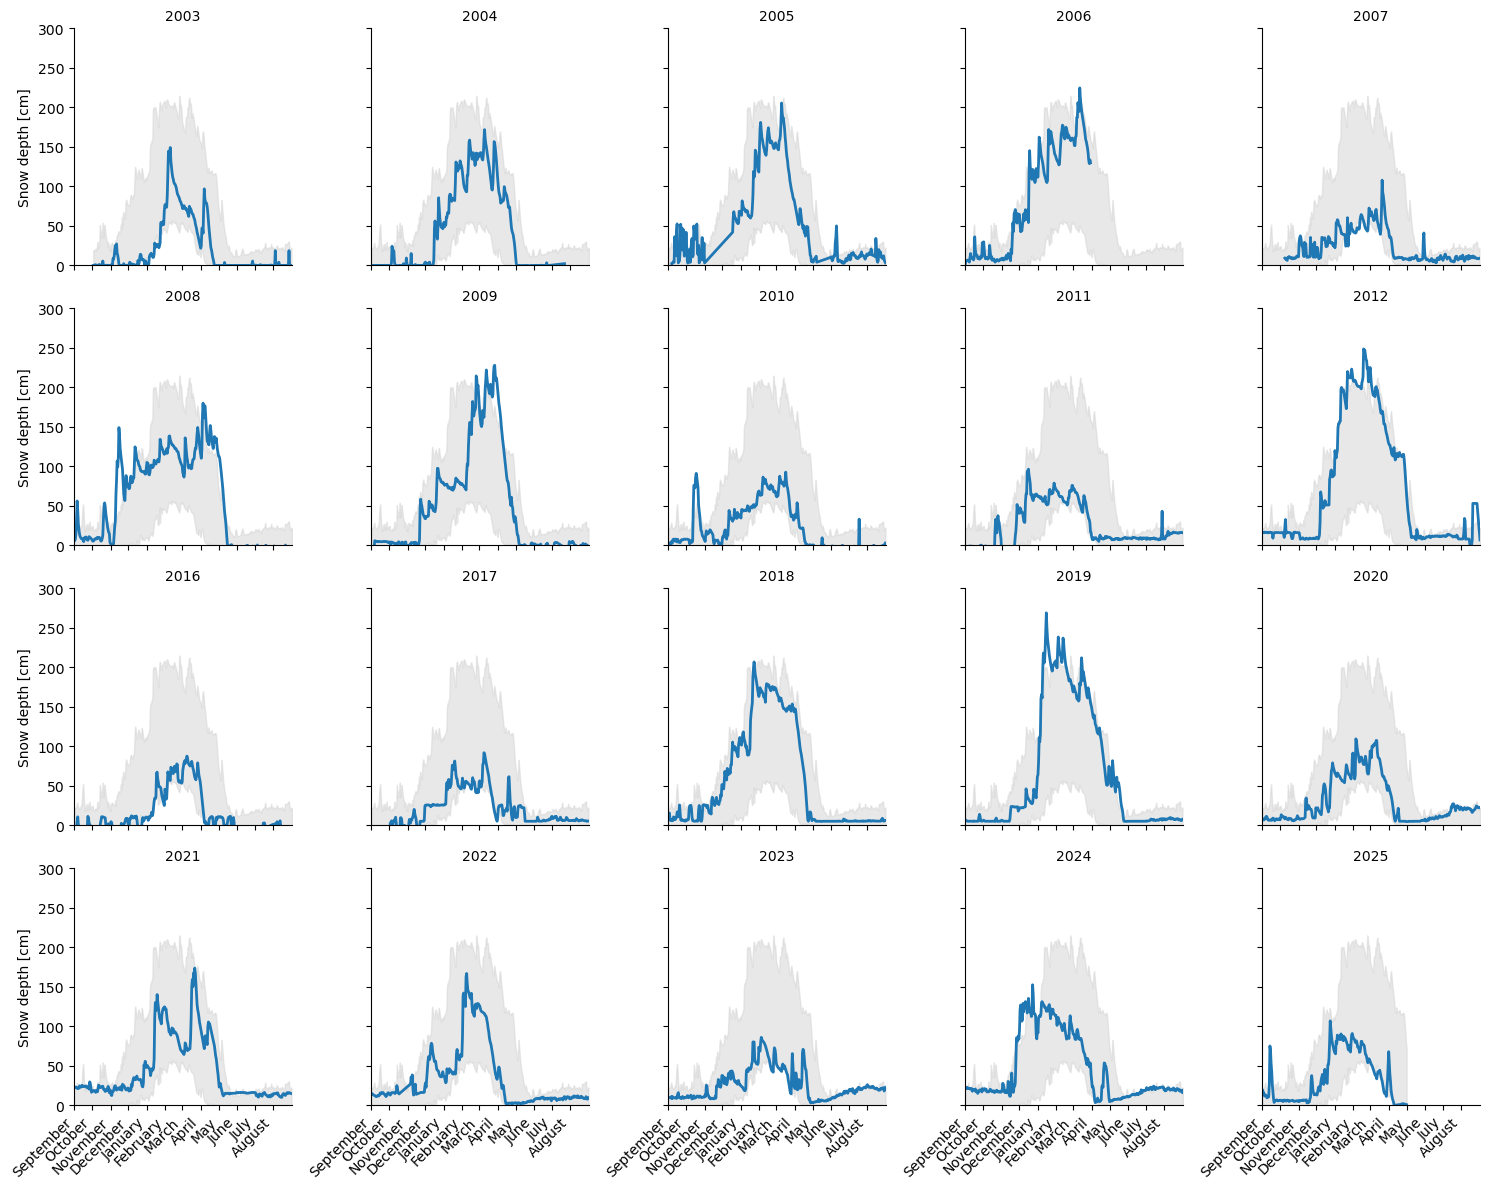

In [9]:
#| code-fold: true

# generate ticklabels
dates_x = pd.date_range(start="2021-09-01", end="2022-08-31", freq="MS")
ticklabels = dates_x.to_series().dt.strftime("%B").values
tickpos = dates_x.to_series().dt.day_of_year.values
dayvals = tickpos.copy()

tickpos[dayvals >= 244] = tickpos[dayvals >= 244] - 243
tickpos[dayvals < 244] = tickpos[dayvals < 244] + 122

g = sns.FacetGrid(df_merged, col="hydro_year", col_wrap=5, sharey=True, sharex=True)


def plot_with_minmax(data, color, **kwargs):
    plt.fill_between(
        data["hydro_doy"],
        data["min"],
        data["max"],
        color="lightgrey",
        alpha=0.5,
    )

    sns.lineplot(
        data=data, x="hydro_doy", y="HS", linewidth=2, label="Hydrological year"
    )


g.map_dataframe(plot_with_minmax)


def set_xlim(color, xmin, xmax, ymax):
    ax = plt.gca()

    ax.set_xticks(tickpos, ticklabels, rotation=45, ha="right")

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((0, ymax))
    ax.set_ylabel("Snow depth [cm]")
    ax.set_xlabel(None)


g.map(set_xlim, xmin=1, xmax=366, ymax=300)

g.set_titles(col_template="{col_name}")
plt.savefig(f"{station}-snow-depth.png", dpi=100)
plt.show()